Copyright Preferred Networks, Inc. and Preferred Computational Chemistry, Inc. as contributors to Matlantis contrib project

# Optunaを利用した吸着構造探索（初級編）

触媒上での反応などでは、触媒表面上に分子が吸着した後に表面上で反応が進行し、その後生成物が触媒表面上から脱離するという過程を扱います。
そうした過程では、表面構造上に分子が存在する吸着構造を取り扱うことになります。
[Atomistic Simulation Tutorialの3.3節](https://docs.matlantis.com/atomistic-simulation-tutorial/ja/3_3_slab_adsorption_energy.html)では、そうした過程における吸着エネルギーについて説明しました。
吸着構造ごとに吸着エネルギーが異なるため、吸着構造の中でも安定なものとそうでないものが存在すると述べました。

では、エネルギー的に安定な吸着構造とはどのようなものでしょうか？
また、そうした構造を知るためにはどうすれば良いでしょうか？
このノートブックでは、安定な吸着構造の探索がブラックボックス最適化問題として定式化することができ、ブラックボックス最適化ソフトウェア[Optuna](https://optuna.org/)によって実際に探索が行うことができることを説明します。

In [1]:
# !pip install -U optuna
# !pip install -U pfp-api-client
#In addition, please install `pfcc_extras`.

まずは、必要なモジュールをインポートしておきます。

In [2]:
import io
import os
import tempfile

from ase import Atoms
from ase.build import bulk, fcc111, molecule, add_adsorbate
from ase.constraints import ExpCellFilter, StrainFilter
from ase.io import write, read
from ase.io.jsonio import write_json, read_json
from ase.optimize import LBFGS, FIRE
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import optuna

import pfp_api_client
from pfp_api_client.pfp.calculators.ase_calculator import ASECalculator
from pfp_api_client.pfp.estimator import Estimator, EstimatorCalcMode

from pfcc_extras.visualize.view import view_ngl

print(f"pfp_api_client: {pfp_api_client.__version__}")

# estimator = Estimator(calc_mode=EstimatorCalcMode.CRYSTAL, model_version="latest")
estimator = Estimator(calc_mode=EstimatorCalcMode.CRYSTAL_U0, model_version="v3.0.0")
calculator = ASECalculator(estimator)

/home/jovyan/.py38/lib/python3.8/site-packages/pfp_api_client/__init__.py:35: UserWarning: New version of pfp-api-client is available. Please consider upgrading by `pip install -U pfp-api-client`.
  warnings.warn(


pfp_api_client: 1.9.1


また、構造を局所最適化するためのユーティリティ関数を用意しておきます。

In [3]:
def get_opt_energy(atoms, fmax=0.001, opt_mode: str = "normal"):    
    atoms.set_calculator(calculator)
    if opt_mode == "scale":
        opt1 = LBFGS(StrainFilter(atoms, mask=[1, 1, 1, 0, 0, 0]), logfile=None)
    elif opt_mode == "all":
        opt1 = LBFGS(ExpCellFilter(atoms), logfile=None)
    else:
        opt1 = LBFGS(atoms, logfile=None)
    opt1.run(fmax=fmax)
    return atoms.get_total_energy()

## Optunaとは

[Optuna](https://optuna.org/)は、Preferred Networks, Incが中心となって開発するオープンソースのブラックボックス最適化ソフトウェアです。
国内外の多くのユーザに利用されており、ハイパーパラメータの最適化から料理のレシピ最適化まで幅広く活用できます。（下図のGitHub Starの変遷をご覧ください。）
開発コミュニティも活発で、2023年6月現在で15人程度のコア開発者、200人近いコントリビュータを持ちます。
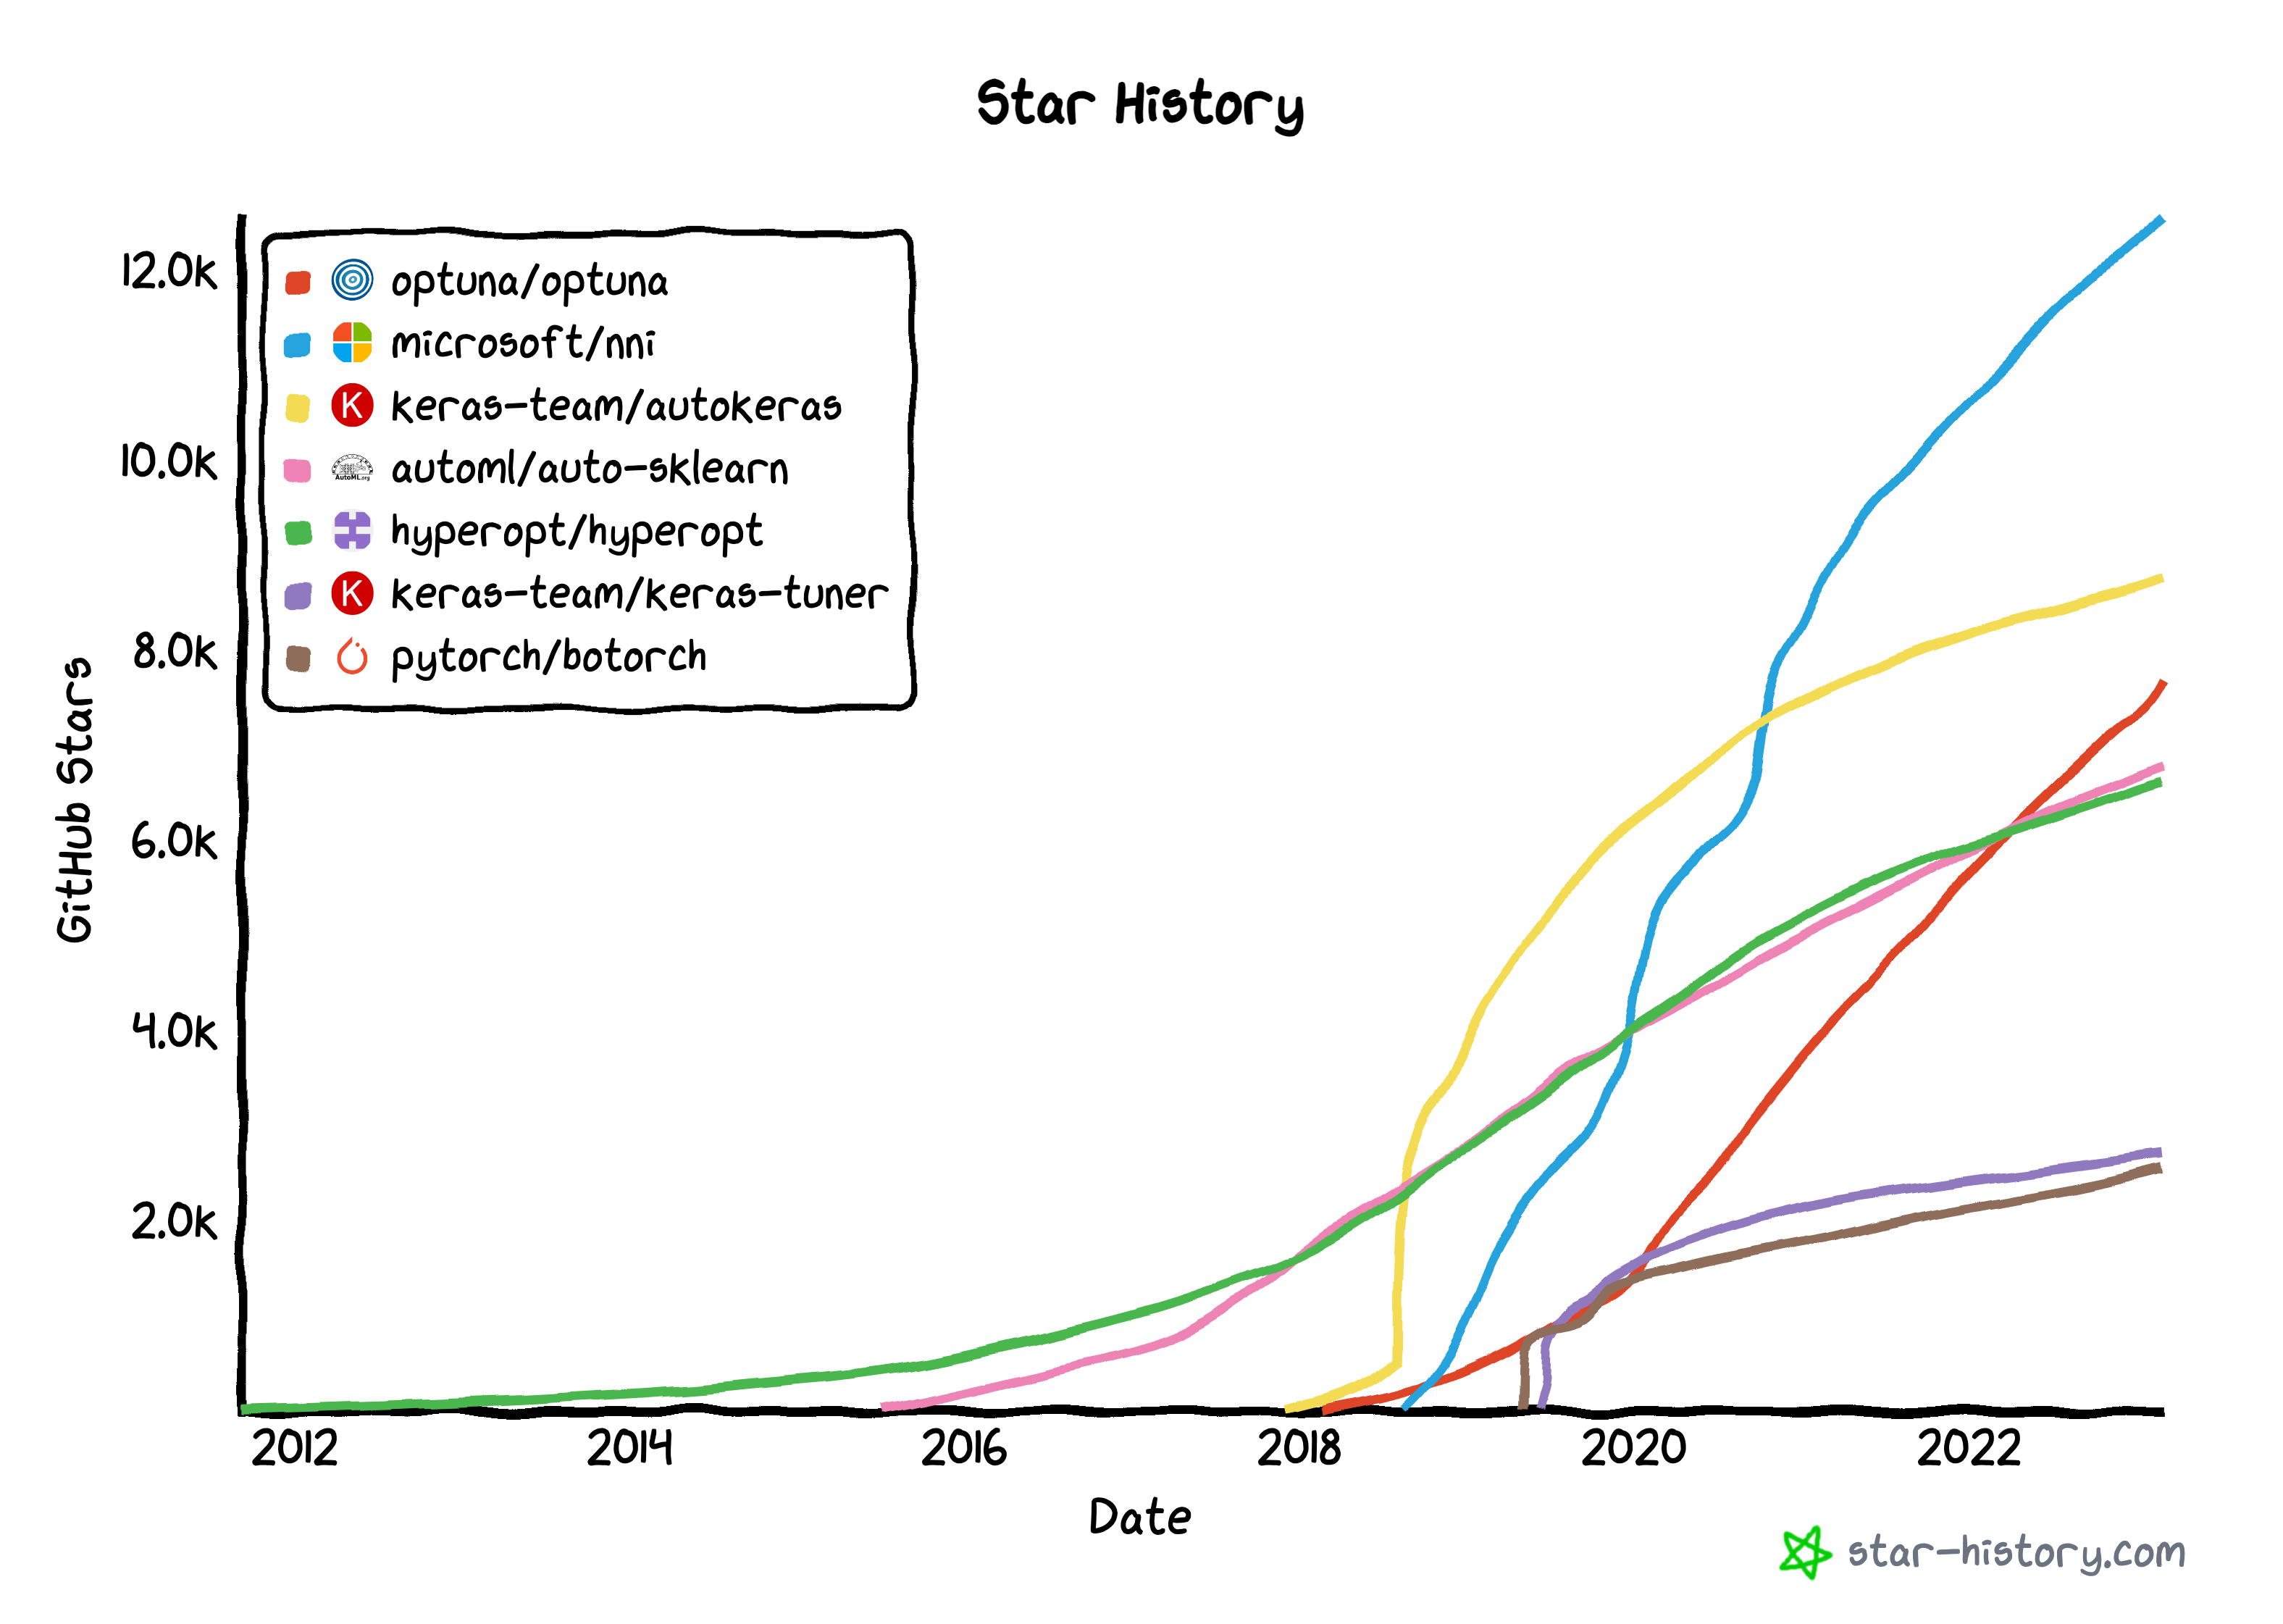

利用の方法は非常に単純で、最適化したい目的関数を定義して、`Study`と呼ばれるクラスのオブジェクトを作成し、その`optimize`メソッドを呼ぶだけです。

[I 2023-06-28 07:20:11,352] A new study created in memory with name: no-name-bf480993-a698-49bb-b577-217375225de0
[I 2023-06-28 07:20:11,362] Trial 0 finished with value: 0.00911928507937446 and parameters: {'x': 0.0954949479259215}. Best is trial 0 with value: 0.00911928507937446.
[I 2023-06-28 07:20:11,367] Trial 1 finished with value: 0.00130882064085087 and parameters: {'x': 0.03617762624676846}. Best is trial 1 with value: 0.00130882064085087.
[I 2023-06-28 07:20:11,379] Trial 2 finished with value: 0.16850122325710123 and parameters: {'x': 0.4104890050380171}. Best is trial 1 with value: 0.00130882064085087.
[I 2023-06-28 07:20:11,385] Trial 3 finished with value: 0.04707649398133608 and parameters: {'x': 0.2169711823753009}. Best is trial 1 with value: 0.00130882064085087.
[I 2023-06-28 07:20:11,395] Trial 4 finished with value: 0.38773775606483946 and parameters: {'x': 0.6226859208821406}. Best is trial 1 with value: 0.00130882064085087.
[I 2023-06-28 07:20:11,402] Trial 5 fini

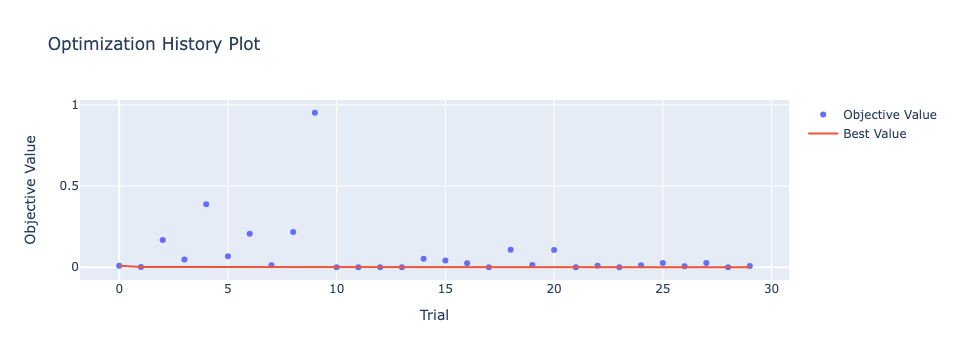

In [4]:
# y = x^2 (0 <= x <= 1)を最小化する例
def objective(trial):
    x = trial.suggest_float("x", 0, 1)
    return x ** 2

study = optuna.create_study()
study.optimize(objective, n_trials=30)
optuna.visualization.plot_optimization_history(study)

このノートブックでは、Optunaを利用して吸着構造の探索を行うことができることを、いくつかの単純な例を通して示します。

## 例：吸着構造の探索（単純版）

[Atomistic Simulation Tutorialの3.3節](https://docs.matlantis.com/atomistic-simulation-tutorial/ja/3_3_slab_adsorption_energy.html)では、吸着エネルギーの計算の例として、白金上の一酸化炭素分子の吸着反応を扱いました。
ここでは、全く同じ反応を対象として吸着構造の探索を行う例を示しましょう。

まずは、探索したい吸着構造を作成するため結晶(bulk)構造、表面(slab)構造、そして吸着させる分子の構造を用意します。
後ほど用いるため、各構造は局所最適化しておきます。

In [5]:
bulk_atoms = bulk("Pt", cubic=True)
bulk_atoms.calc = calculator
E_bulk = get_opt_energy(bulk_atoms, fmax=1e-4, opt_mode="scale")
E_bulk

-21.811600286477884

In [6]:
def create_slab():
    a = np.mean(np.diag(bulk_atoms.cell))
    slab =  fcc111("Pt", a=a, size=(4, 4, 4), vacuum=40.0, periodic=True)
    slab.calc = calculator
    E_slab = get_opt_energy(slab, fmax=1e-4, opt_mode="normal")
    return slab, E_slab 

slab, E_slab = create_slab()
view_ngl(slab, representations=["ball+stick"])

In [7]:
def create_mol():
    mol = molecule("CO")
    mol.calc = calculator
    E_mol = get_opt_energy(mol, fmax=1e-4)
    return mol, E_mol

mol, E_mol = create_mol()
view_ngl(mol, representations=["ball+stick"])

さて、それでは作成した一酸化炭素分子を白金の表面構造に吸着させてみましょう。
分子が表面構造のどの部分に吸着するかは自明ではありません。
今回の表面構造に対しては、安定な構造として以下のように４通りの吸着サイトが知られています。
それぞれ、
 - `ontop`: ある１つの原子の上
 - `bridge`:　ある２つの原子の間
 - `fcc`: ３つの原子の間で、2層目には原子が存在しない位置
 - `hcp`: ３つの原子の間で、2層目の原子の直上の位置
 
です。



Optunaを利用した吸着構造の探索は、逐次的な最適化として行われます。
すなわち、各試行（ブラックボックス最適化では”トライアル(trial)”と呼ばれます。）において、ある一つの吸着構造が選択され、その吸着構造に対して実際に吸着反応を起こします。
選択された吸着構造ごとに吸着エネルギーが計算され、計算した吸着エネルギーがなるべく小さくなるように吸着構造の選択が行われます。
このように、吸着構造を選択しその吸着エネルギーを計算し返す関数が目的関数で、この関数を最小化するようにOptunaを利用します。

これを実行するコードが以下です。
`objective`関数は目的関数で、作成した表面構造と分子の構造に対し、Optunaの`Trial`オブジェクトを用いて得た吸着サイト（ここでは`ontop`, `bridge`, `fcc`, `hcp`の４通りの文字列から選びます。）を指定して吸着反応を起こしています（`add_adsorbate`関数）。
最後に、得られた吸着構造を局所最適化し、吸着エネルギーを返します。
この目的関数をOptunaの`Study`オブジェクト（これは一連のトライアルからなる一つの最適化全体を表します。）の`optimize`メソッドに渡して、最適化を実行しています。

In [8]:
def objective(trial):
    slab, E_slab = create_slab()
    mol, E_mol = create_mol()
    
    site = trial.suggest_categorical("site", ["ontop", "bridge", "fcc", "hcp"])
    add_adsorbate(slab, mol, 3.0, site)
    E_slab_mol = get_opt_energy(slab, fmax=1e-3)

    return E_slab_mol - E_slab - E_mol

study = optuna.create_study()
study.optimize(objective, n_trials=30)
print(f"Best trial is #{study.best_trial.number}")
print(f"    Its adsorption energy is {study.best_value}")
print(f"    Its adsorption site is {study.best_params}")

[I 2023-06-28 07:20:31,437] A new study created in memory with name: no-name-90a3eb67-8170-4a37-9b01-7f3f1fb3af5c
[I 2023-06-28 07:20:35,314] Trial 0 finished with value: -1.8874286328268894 and parameters: {'site': 'fcc'}. Best is trial 0 with value: -1.8874286328268894.
[I 2023-06-28 07:20:40,202] Trial 1 finished with value: -1.8671060815809533 and parameters: {'site': 'hcp'}. Best is trial 0 with value: -1.8874286328268894.
[I 2023-06-28 07:20:44,437] Trial 2 finished with value: -1.7466700711286087 and parameters: {'site': 'ontop'}. Best is trial 0 with value: -1.8874286328268894.
[I 2023-06-28 07:20:50,202] Trial 3 finished with value: -1.8753556580250432 and parameters: {'site': 'bridge'}. Best is trial 0 with value: -1.8874286328268894.
[I 2023-06-28 07:20:55,626] Trial 4 finished with value: -1.8753724292873866 and parameters: {'site': 'bridge'}. Best is trial 0 with value: -1.8874286328268894.
[I 2023-06-28 07:21:00,895] Trial 5 finished with value: -1.8753323157251138 and pa

Best trial is #20
    Its adsorption energy is -1.8874508359831506
    Its adsorption site is {'site': 'fcc'}


探索の結果、fccサイトが最も安定であることがわかりました。これは[Atomistic Simulation Tutorialの3.3節](https://docs.matlantis.com/atomistic-simulation-tutorial/ja/3_3_slab_adsorption_energy.html)で得た結果と一致しています。

Optunaには豊富な可視化機能が実装されており、探索の過程を可視化したり、探索した構造を定めるパラメータ（今回は吸着サイト）ごとに吸着エネルギーに対する寄与の分布を可視化することができます。

In [9]:
optuna.visualization.plot_optimization_history(study)

今回は探索すべき構造が吸着サイトの４通りしかないので、この実行では1トライアル目でfcc構造を見つけてしまっていることがわかります。

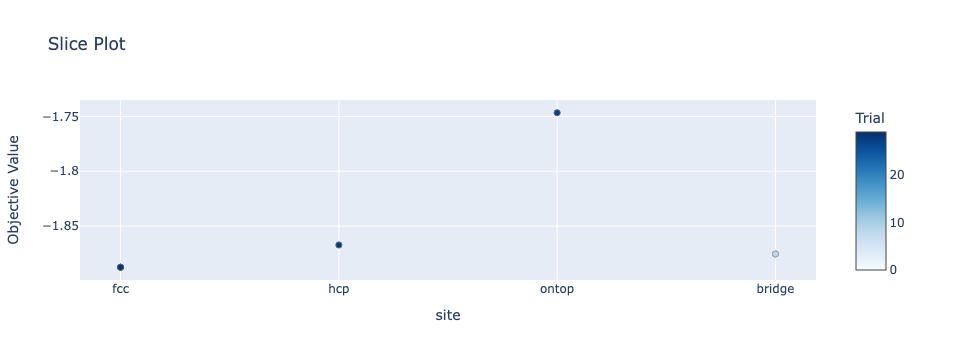

In [10]:
optuna.visualization.plot_slice(study)

4つの吸着サイトの中ではfcc構造が最もエネルギー的に安定であることがわかります。

## 例：吸着構造の探索 (少し複雑版)

上の例では、４つの吸着サイトの中で最も安定な構造がどれかを探索するという単純な例で、吸着構造探索にOptunaを利用する方法を説明しました。
ここではもう少し複雑な例として、吸着させる分子(の重心)の吸着反応前の位置（座標および回転）を探索することで、安定な吸着構造の探索を行なってみることにします。まずは、構造を文字列に変換するユーティリティ関数を用意します。



In [11]:
import io

def atoms_to_json(atoms):
    f = io.StringIO()
    write(f, atoms, format="json")
    return f.getvalue()


def json_to_atoms(atoms_str):
    return read(io.StringIO(atoms_str), format="json")

上記の関数を用いることで、`Atoms`を文字列として保存したり、文字列から`Atoms`に復元することができます。

In [12]:
mol_json_str = atoms_to_json(mol)
mol2 = json_to_atoms(mol_json_str)

print(f"{mol_json_str=}")
view_ngl(mol2, representations=["ball+stick"])

mol_json_str='{"1": {\n "calculator": "asecalculator",\n "calculator_parameters": {},\n "cell": {"__ndarray__": [[3, 3], "float64", [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]},\n "ctime": 23.488978156630242,\n "mtime": 23.488978156630242,\n "numbers": {"__ndarray__": [[2], "int64", [8, 6]]},\n "pbc": {"__ndarray__": [[3], "bool", [false, false, false]]},\n "positions": {"__ndarray__": [[2, 3], "float64", [0.0, 0.0, 0.48941706312793415, 0.0, 0.0, -0.6537510631279342]]},\n "unique_id": "3cd9f156660ebd0b61a8e72e9187c6bc",\n "user": null},\n"ids": [1],\n"nextid": 2}\n'


以下に、Optunaを利用した最適化コードを示します。
まず`Study`を作ってからの処理を見てみてください。
```
study = optuna.create_study()

slab, E_slab = create_slab()
study.set_user_attr("slab", atoms_to_json(slab))
study.set_user_attr("E_slab", E_slab)

mol, E_mol = create_mol()
study.set_user_attr("mol", atoms_to_json(mol))
study.set_user_attr("E_mol", E_mol)
```
上の例ではトライアルごとに表面構造と吸着分子を作成し局所最適化していましたが、これは毎回行う必要がありません。
そこで、最適化処理(`Study.optimize`)を呼ぶ前に表面面構造と吸着分子を作成し、それらを`Study`の`user_attrs`に保存しておくことにします。
その際、`Atoms`オブジェクトをJSON形式の文字列に変換する`atoms_to_json`関数を利用しています。

次に、目的関数`obejctive`の変更を見てください。
まず、保存しておいた表面構造と吸着分子を`Trial`から復元します。
その際、JSON形式の文字列を`Atoms`オブジェクトに変換する`json_to_atoms`関数を利用しています。

また、吸着分子の重心の反応前の位置を探索すると以下のようになります。
[オイラー角](https://ja.wikipedia.org/wiki/%E3%82%AA%E3%82%A4%E3%83%A9%E3%83%BC%E8%A7%92)によって原点の周りの回転を指定し(`phi`, `theta`, `psi`)、xyz座標によって重心の位置を指定(`x_pos`, `y_pos`, `z_hig`)しています。
角度について縮退を避けるため、`theta`は0°から180°の間にあるように変換しています。

さらに、各トライアルにおいて、局所最適化を行なった後の吸着構造を後から参照できるようにOptunaのストレージに保存しています。
```
trial.set_user_attr("structure", atoms_to_json(slab))
```
このストレージはデフォルトではメモリ上に作られるので、ノートブックインスタンスを閉じると失われてしまいます。
もしファイルやRDBに永続化したいならば、`Study`オブジェクトを作成する際に`storage`引数を適切に指定してください。
（[参考文献](https://optuna.readthedocs.io/en/stable/tutorial/20_recipes/001_rdb.html#sphx-glr-tutorial-20-recipes-001-rdb-py)）

In [12]:
def objective(trial):
    slab = json_to_atoms(trial.study.user_attrs["slab"])
    E_slab = trial.study.user_attrs["E_slab"]
    
    mol = json_to_atoms(trial.study.user_attrs["mol"])
    E_mol = trial.study.user_attrs["E_mol"]
    
    phi = 180. * trial.suggest_float("phi", -1, 1)
    theta = np.arccos(trial.suggest_float("theta", -1, 1))*180./np.pi
    psi = 180 * trial.suggest_float("psi", -1, 1)
    x_pos = trial.suggest_float("x_pos", 0, 0.5)
    y_pos = trial.suggest_float("y_pos", 0, 0.5)
    z_hig = trial.suggest_float("z_hig", 1, 5)
    xy_position=np.matmul([x_pos,y_pos,0], slab.cell)[:2]
    mol.euler_rotate(phi=phi, theta=theta, psi=psi)
    
    add_adsorbate(slab, mol, z_hig, xy_position)
    E_slab_mol = get_opt_energy(slab, fmax=1e-3)
    
    trial.set_user_attr("structure", atoms_to_json(slab))
    
    return E_slab_mol - E_slab - E_mol

study = optuna.create_study()

slab, E_slab = create_slab()
study.set_user_attr("slab", atoms_to_json(slab))
study.set_user_attr("E_slab", E_slab)

mol, E_mol = create_mol()
study.set_user_attr("mol", atoms_to_json(mol))
study.set_user_attr("E_mol", E_mol)

study.optimize(objective, n_trials=30)
print(f"Best trial is #{study.best_trial.number}")
print(f"    Its adsorption energy is {study.best_value}")
print(f"    Its adsorption position is")
print(f"        phi  : {study.best_params['phi']}")
print(f"        theta: {study.best_params['theta']}")
print(f"        psi. : {study.best_params['psi']}")
print(f"        x_pos: {study.best_params['x_pos']}")
print(f"        y_pos: {study.best_params['y_pos']}")
print(f"        z_hig: {study.best_params['z_hig']}")

[I 2023-06-22 07:52:43,315] A new study created in memory with name: no-name-05c9ff48-36df-4154-a4ec-acdfc79af33b
[I 2023-06-22 07:52:53,632] Trial 0 finished with value: -1.7466693015211998 and parameters: {'phi': 0.673261826542781, 'theta': -0.08145613400482099, 'psi': 0.012660177285633178, 'x_pos': 0.21368073140208993, 'y_pos': 0.083302211884698, 'z_hig': 2.1579626406916224}. Best is trial 0 with value: -1.7466693015211998.
[I 2023-06-22 07:53:08,445] Trial 1 finished with value: -1.7466758266902556 and parameters: {'phi': 0.9855222409325082, 'theta': 0.016492100447592195, 'psi': 0.05601268852436658, 'x_pos': 0.2690629423392075, 'y_pos': 0.17557497446318515, 'z_hig': 3.0864597917564565}. Best is trial 1 with value: -1.7466758266902556.
[I 2023-06-22 07:53:15,151] Trial 2 finished with value: -1.7466824375789596 and parameters: {'phi': -0.14582683865571022, 'theta': 0.7177929241649788, 'psi': -0.23399827718877608, 'x_pos': 0.2587606449599002, 'y_pos': 0.29965098318287636, 'z_hig': 2.

Best trial is #27
    Its adsorption energy is -1.887434014767626
    Its adsorption position is
        phi  : -0.1548418507612546
        theta: 0.5206345752720033
        psi. : 0.6195729275282571
        x_pos: 0.11781482121159434
        y_pos: 0.2287451486234747
        z_hig: 1.3347112513526806


探索の過程や得られた構造を可視化してみましょう。まずは先ほども行った探索の過程の可視化からです。

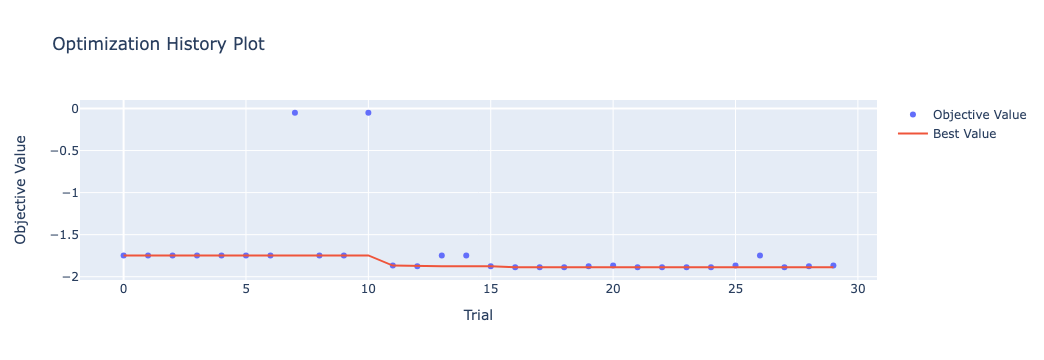

In [16]:
optuna.visualization.plot_optimization_history(study)

数トライアルで収束している様子が見て取れます。
また、各探索パラメータが吸着エネルギーにどのように寄与しているのかを可視化してみましょう。

In [17]:
optuna.visualization.plot_slice(study)

角度パラメータ(`phi`, `theta`, `psi`)については
- `phi`: `[0, 1]`
- `theta`: `[0, 1]`
- `psi`: `[-1, 0]`
に集中していることがわかります。
また、座標パラメータ(`x_pos`, `y_pos`, `z_hig`)については
- `x_pos`: `[0, 0.2]`
- `y_pos`: `[0.2, 0.4]`
- `z_hig`: `[1, 3]`
に集中していることがわかります。
したがって、続けて探索を行う際は各パラメータの範囲を
```
phi = 180. * trial.suggest_float("phi", 0, 1)
theta = np.arccos(trial.suggest_float("theta", 0, 1))*180./np.pi
psi = 180 * trial.suggest_float("psi", -1, 0)
x_pos = trial.suggest_float("x_pos", 0, 0.2)
y_pos = trial.suggest_float("y_pos", 0.2, 0.4)
z_hig = trial.suggest_float("z_hig", 1, 3)
```
のように制限すると、よりきめ細かい探索ができる可能性があるとわかります。
このように一定のトライアルだけ探索したところで、Optunaの可視化機能を用いて分析を行うことで、その後の探索の効率を上げることが可能です。

また、得られた構造を可視化してみましょう。
我々はトライアルごとに、その`user_attrs`に構造を保存しておいたので、これを取り出すことができます。

In [18]:
slab = json_to_atoms(study.best_trial.user_attrs["structure"])
view_ngl(slab, representations=["ball+stick"])

分子の位置を自由に動かして探索を行いましたが、確かにFCCサイトへの吸着が安定な吸着構造として得られていることがわかります。

また、探索の過程で試された他の構造も可視化して確認しておきましょう。

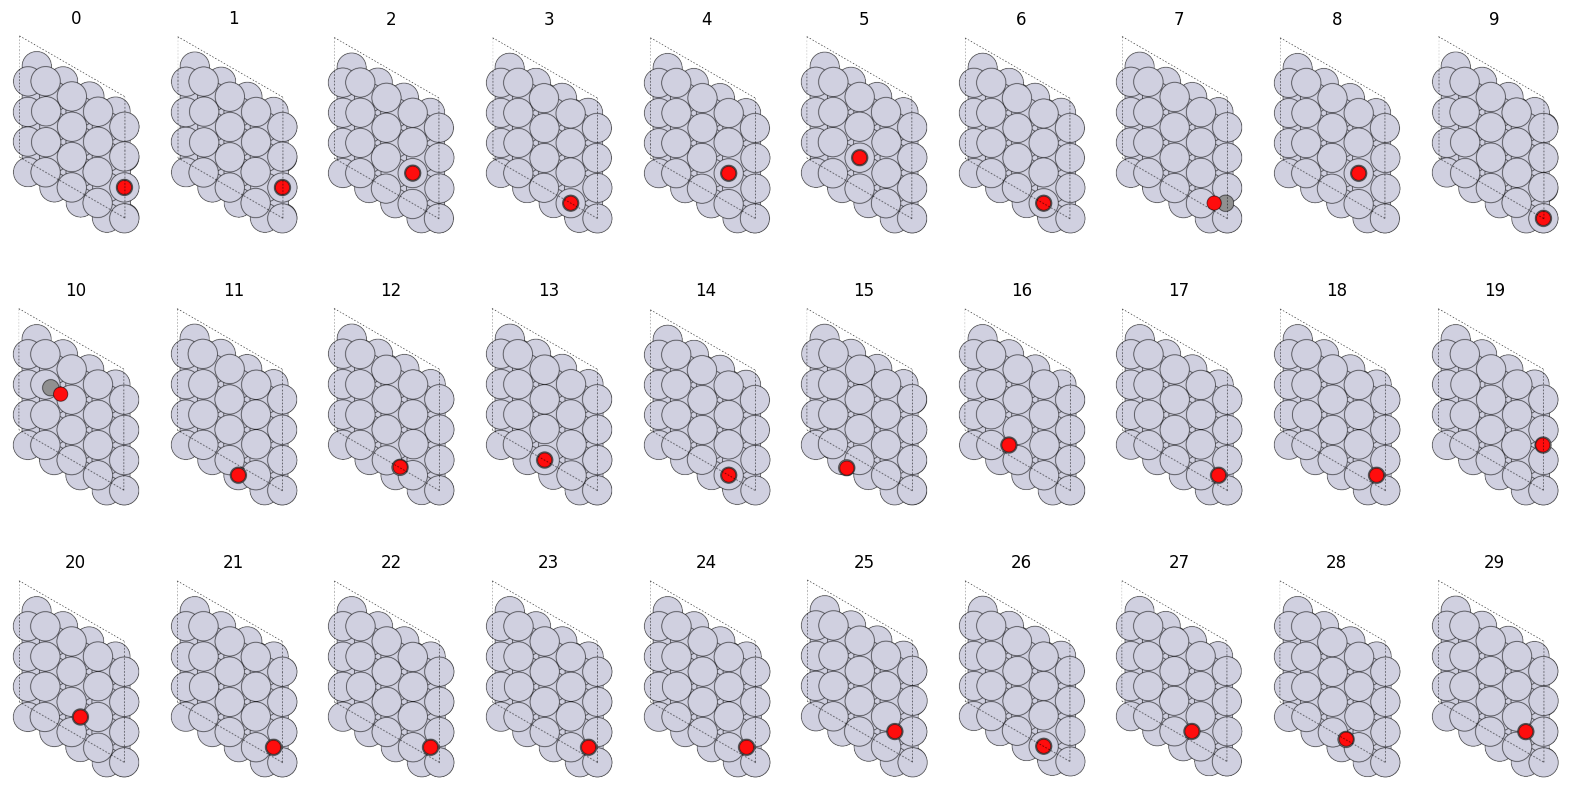

In [20]:
os.makedirs("output", exist_ok=True)

fig, axes = plt.subplots(len(study.trials) // 10, 10, figsize=(20, 10))
for trial in study.trials:
    slab = json_to_atoms(trial.user_attrs["structure"])
    write(f"output/{trial.number}.png", slab, rotation="0x,0y,90z")
    ax = axes[trial.number // 10][trial.number % 10]
    ax.imshow(mpimg.imread(f"output/{trial.number}.png"))
    ax.set_axis_off()
    ax.set_title(trial.number)
fig.show()

今回の探索では、吸着サイトの対称性に関する事前知識を利用せず3次元座標をランダムに振って探索を進めましたが、その過程で4つの吸着サイトが探索されていることが見て取れます。

最後に、各構造を細かく確認できるようにngl_viewerによる可視化も示します。

In [22]:
slabs = []
for trial in study.trials:
    slab = json_to_atoms(trial.user_attrs["structure"])
    slabs.append(slab)
view_ngl(slabs, representations=["ball+stick"], replace_structure=True)